In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, davies_bouldin_score
import pickle

In [48]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A', '#e8da6f', '#c33b43', 
               '#9DBF9E', '#64a0e0', '#343934', '#280003','#cd5a61', '#913d27', 
               '#F46036', '#248232',  '#bea602', '#0a6682', '#646536', '#624763', '#2F1847', 
               '#FF7B9C', '#66A182', '#94849B', '#ACD8AA', '#F48498', '#B30089']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

In [49]:
df_wind = pd.read_csv('../../1_data_analysis_and_preproc/intermediate/wind/df_wind.csv')

In [50]:
df_wind.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm
0,11,2021-01-01 00:00:00,8.3,296.0,802.0,15.51,-2.0,9.0,1
1,11,2021-01-01 00:10:00,8.9,306.0,832.0,15.74,-2.0,9.0,1
2,11,2021-01-01 00:20:00,8.1,298.0,666.0,14.88,-2.0,10.0,1
3,11,2021-01-01 00:30:00,7.9,298.0,541.0,14.03,-2.0,10.0,1
4,11,2021-01-01 00:40:00,8.1,296.0,625.0,14.64,-2.0,10.0,1


less percentage to haev more or less the same amount of rows/information and not to take a lot of computational resources

In [52]:
np.random.seed(10)

# Define the desired subset size per asset (adjust as needed)
subset_size_percentage = 0.0055  # Adjust as needed

# Get the unique asset identifiers from the original DataFrame
unique_assets = df_wind['asset_id'].unique()

# Find the minimum number of rows among all assets
min_rows = min(df_wind['asset_id'].value_counts())

# Calculate the subset size based on the minimum number of rows
subset_size = int(subset_size_percentage * min_rows)

# Initialize an empty list to store the sampled data
subset_data = []

# Iterate over each asset, sample rows, and append to subset_data
for asset in unique_assets:
    # Filter the DataFrame for the current asset
    asset_df = df_wind[df_wind['asset_id'] == asset]
    
    # Sample rows from the asset DataFrame
    sampled_group = asset_df.sample(n=subset_size, replace=False)
    subset_data.append(sampled_group)

# Concatenate the sampled data from all assets into a single DataFrame
df_subset = pd.concat(subset_data)


In [53]:
df_subset['asset_id'].nunique()

71

In [54]:
len(df_subset)

46008

In [55]:
df_subset = df_subset.reset_index(drop=True)

wind_direction, power_average, exterior_temperature

In [56]:
df_subset

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm
0,11,2023-01-28 15:20:00,5.60,380.00,251.00,11.20,6.00,20.00,1
1,11,2021-05-14 05:30:00,7.60,-78.00,704.00,15.42,4.00,16.00,1
2,11,2023-02-08 14:30:00,8.60,435.00,928.00,15.97,5.00,12.00,1
3,11,2021-06-10 21:00:00,5.00,-405.00,188.00,10.49,19.00,33.00,1
4,11,2021-11-10 02:00:00,5.10,77.00,221.00,10.89,10.00,23.00,1
...,...,...,...,...,...,...,...,...,...
46003,512,2021-12-10 13:30:00,10.82,289.15,1995.14,13.94,11.63,17.21,5
46004,512,2022-02-24 05:10:00,0.79,183.03,-0.73,0.00,13.20,19.46,5
46005,512,2021-08-10 20:30:00,5.12,329.00,185.68,8.25,24.87,32.67,5
46006,512,2022-03-13 21:10:00,3.29,165.46,57.20,7.49,6.74,14.19,5


In [57]:
X = df_subset[['asset_id','read_at' ,'wind_direction', 'power_average', 'exterior_temperature']]
X.head()

,asset_id,read_at,wind_direction,power_average,exterior_temperature
0,11,2023-01-28 15:20:00,380.0,251.0,6.0
1,11,2021-05-14 05:30:00,-78.0,704.0,4.0
2,11,2023-02-08 14:30:00,435.0,928.0,5.0
3,11,2021-06-10 21:00:00,-405.0,188.0,19.0
4,11,2021-11-10 02:00:00,77.0,221.0,10.0


In [58]:
X.dtypes

asset_id                  int64
read_at                  object
wind_direction          float64
power_average           float64
exterior_temperature    float64
dtype: object

In [59]:
X['read_at'] = pd.to_datetime(X['read_at'])

/tmp/ipykernel_17751/2166665197.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['read_at'] = pd.to_datetime(X['read_at'])


In [60]:
X['read_at'] = X['read_at'].apply(pd.Timestamp.timestamp).values.reshape(-1, 1)

/tmp/ipykernel_17751/3417196857.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['read_at'] = X['read_at'].apply(pd.Timestamp.timestamp).values.reshape(-1, 1)


In [61]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46008 entries, 0 to 46007
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   asset_id              46008 non-null  int64  
 1   read_at               46008 non-null  float64
 2   wind_direction        46008 non-null  float64
 3   power_average         46008 non-null  float64
 4   exterior_temperature  46008 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 1.8 MB


In [62]:
X = X.astype(np.float32)

In [63]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46008 entries, 0 to 46007
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   asset_id              46008 non-null  float32
 1   read_at               46008 non-null  float32
 2   wind_direction        46008 non-null  float32
 3   power_average         46008 non-null  float32
 4   exterior_temperature  46008 non-null  float32
dtypes: float32(5)
memory usage: 898.7 KB


In [64]:
X_grouped = X.groupby('asset_id')

In [65]:
def zoom_in_plot(X_train, y_pred, km, sz, title:str):
    fig = plt.figure(figsize=(16, 12))
    gs = gridspec.GridSpec(3, 4, width_ratios=[5, 1, 3, 1], height_ratios=[1, 1, 1])

    for yi in range(3):
        # Main plot with more width
        ax = plt.subplot(gs[yi, 0])
        for xx in X_train[y_pred == yi]:  
            ax.plot(xx.ravel(), "k-", alpha=0.2)
        ax.plot(km.cluster_centers_[yi].ravel(), "r-")
        ax.set_xlim(0, sz)
        ax.set_ylim(-4, 4)
        ax.text(0.55, 0.85, 'Cluster %d' % (yi + 1), transform=ax.transAxes)
        if yi == 0:
            ax.set_title(f"{title} $k$-means")

        # Zoomed-in plot
        axins = plt.subplot(gs[yi, 2])
        for xx in X_train[y_pred == yi]:  
            axins.plot(xx.ravel(), "k-", alpha=0.2)
        axins.plot(km.cluster_centers_[yi].ravel(), "r-")
        axins.set_xlim(200, 220)
        axins.set_ylim(-3, 3)
        mark_inset(ax, axins, loc1=2, loc2=3, fc="None", ec="g")

    # Adjust spacing between the two plots in the same row
    plt.subplots_adjust(wspace=0)

    # plt.tight_layout()
    plt.show()

## Time Series Clustering with all important variables

https://tslearn.readthedocs.io/en/stable/auto_examples/clustering/plot_kmeans.html#sphx-glr-auto-examples-clustering-plot-kmeans-py

### Euclidean k-Means

In [66]:
def clustering_score(estimator, X, silhouette_weight=0.5, davies_bouldin_weight=0.5):
    labels = estimator.fit_predict(X)
    silhouette = silhouette_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    final_score = silhouette_weight * silhouette + davies_bouldin_weight * davies_bouldin
    return final_score

In [67]:
X_train = X.loc[:,'read_at':]

In [68]:
seed = 0

In [69]:
# Define the parameter grid
param_grid = {
    'n_clusters': [2, 3, 4, 5, 10],
}

euc_k_means_clust = TimeSeriesKMeans(verbose=False, random_state=seed)

# Initialize GridSearchCV
grid_search = GridSearchCV(euc_k_means_clust, param_grid, scoring=clustering_score, cv=2, verbose=2, n_jobs=-1)

# Perform grid search
grid_search.fit(X_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END .......................................n_clusters=2; total time= 1.9min
[CV] END .......................................n_clusters=2; total time= 1.9min
[CV] END .......................................n_clusters=3; total time= 2.9min
[CV] END .......................................n_clusters=3; total time= 3.0min
[CV] END .......................................n_clusters=5; total time= 3.7min
[CV] END .......................................n_clusters=5; total time= 3.7min
[CV] END .......................................n_clusters=4; total time= 3.9min
[CV] END .......................................n_clusters=4; total time= 4.0min
[CV] END ......................................n_clusters=10; total time= 3.1min
[CV] END ......................................n_clusters=10; total time= 3.2min


GridSearchCV(cv=2, estimator=TimeSeriesKMeans(random_state=0, verbose=False),
             n_jobs=-1, param_grid={'n_clusters': [2, 3, 4, 5, 10]},
             scoring=<function clustering_score at 0x7ff1731f2700>, verbose=2)

In [70]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_clusters,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,54.258021,3.276798,58.818202,2.712446,2,{'n_clusters': 2},0.563268,0.562967,0.563118,0.000151,1
1,98.333772,8.336646,78.891429,8.579330,3,{'n_clusters': 3},0.544651,0.545039,0.544845,0.000194,2
2,138.871176,2.966390,99.484386,0.719008,4,{'n_clusters': 4},0.536519,0.536509,0.536514,0.000005,3
3,124.775011,6.970600,99.533108,6.426339,5,{'n_clusters': 5},0.531615,0.531164,0.531390,0.000225,4
4,119.355677,1.918456,68.853123,0.860249,10,{'n_clusters': 10},0.520294,0.521065,0.520679,0.000385,5


In [71]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best silhouette score
best_score = grid_search.best_score_
print("Best Clustering Score:", best_score)

Best Parameters: {'n_clusters': 2}
Best Clustering Score: 0.5631175671566353


In [72]:
# Grouping by 'asset_id' and storing each group as an array
grouped_arrays_all = [group[['read_at', 'wind_direction', 'power_average', 'exterior_temperature']].values \
                    for _, group in X.groupby('asset_id')]

In [73]:
X_train = grouped_arrays_all

In [74]:
seed = 42

In [75]:
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)

sz = X_train.shape[1]

using 3 clusters as its the second best clustering partition and then the can be more distributed

Euclidean k-means
4866.979 --> 2475.943 --> 2475.943 --> 


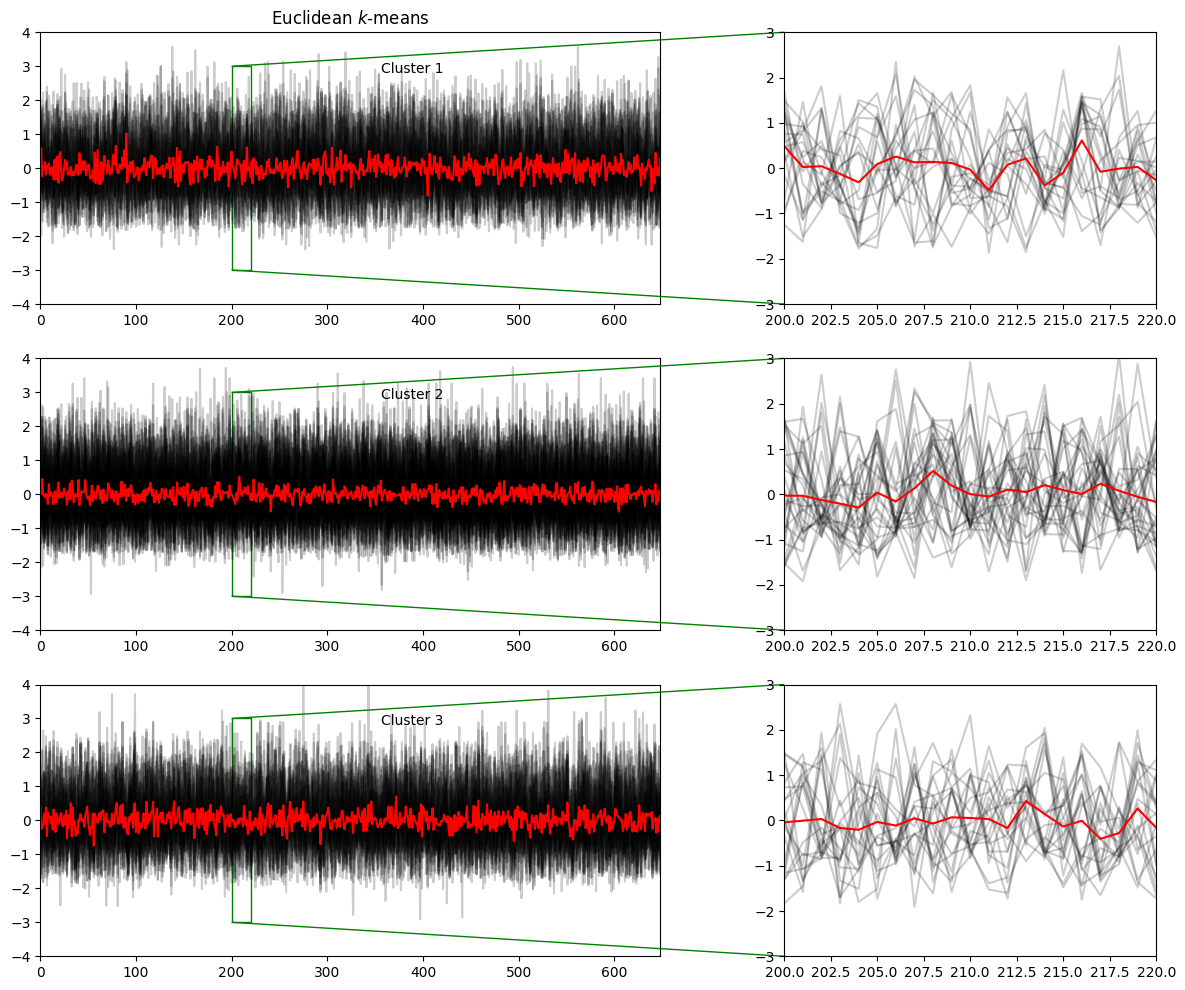

In [76]:
# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=3, verbose=True, random_state=seed)
y_pred_euclidean = km.fit_predict(X_train)

zoom_in_plot(X_train, y_pred_euclidean, km, sz, 'Euclidean')


In [78]:
with open('intermediate_with_out/euclidean_wind.pickle', 'wb') as f:
    pickle.dump(km, f)

In [79]:
assets_per_cluster_euclidean = pd.DataFrame()

assets_per_cluster_euclidean['asset_id'] = df_subset['asset_id'].unique()
assets_per_cluster_euclidean['cluster_label'] = y_pred_euclidean

In [80]:
assets_clusters = assets_per_cluster_euclidean.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [0, 2, 5, 8, 11, 13, 19, 26, 27, 28, 33, 35, 37, 41, 47, 51, 52, 56, 60, 70]
Cluster 1: [1, 7, 10, 15, 16, 18, 22, 23, 24, 25, 30, 31, 32, 34, 36, 38, 43, 46, 48, 49, 50, 53, 55, 58, 61, 64, 65, 67, 68, 69]
Cluster 2: [3, 4, 6, 9, 12, 14, 17, 20, 21, 29, 39, 40, 42, 44, 45, 54, 57, 59, 62, 63, 66]


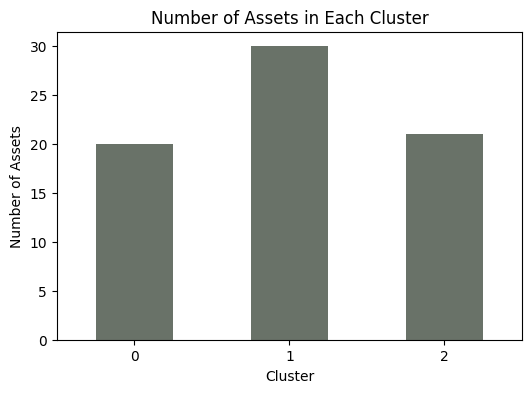

In [81]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = assets_per_cluster_euclidean['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [82]:
asset_per_cluster = pd.DataFrame(columns=['Metric', 'Cluster 0', 'Cluster 1', 'Cluster 2'])

for cluster_label, count in cluster_counts.items():
    column_name = f'Cluster {cluster_label}'  # Generate column name dynamically
    asset_per_cluster.loc[0, column_name] = count

asset_per_cluster.loc[0, 'Metric'] = 'Euclidean'

asset_per_cluster

,Metric,Cluster 0,Cluster 1,Cluster 2
0,Euclidean,20,30,21


In [102]:
merged_df = df_wind.merge(assets_per_cluster_euclidean, on='asset_id', how='left')

In [104]:
merged_df.to_csv('intermediate_with_out/results_raw_wind_euclidean.csv', index = False)

### DBA k-Means

In [83]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=3,
                          n_init=2,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=seed)

y_pred_DBA = dba_km.fit_predict(X_train)

DBA k-means
Init 1


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


3004.699 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s


1986.921 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s


1986.921 --> 
Init 2


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s


3001.017 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


1983.978 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s


1983.978 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


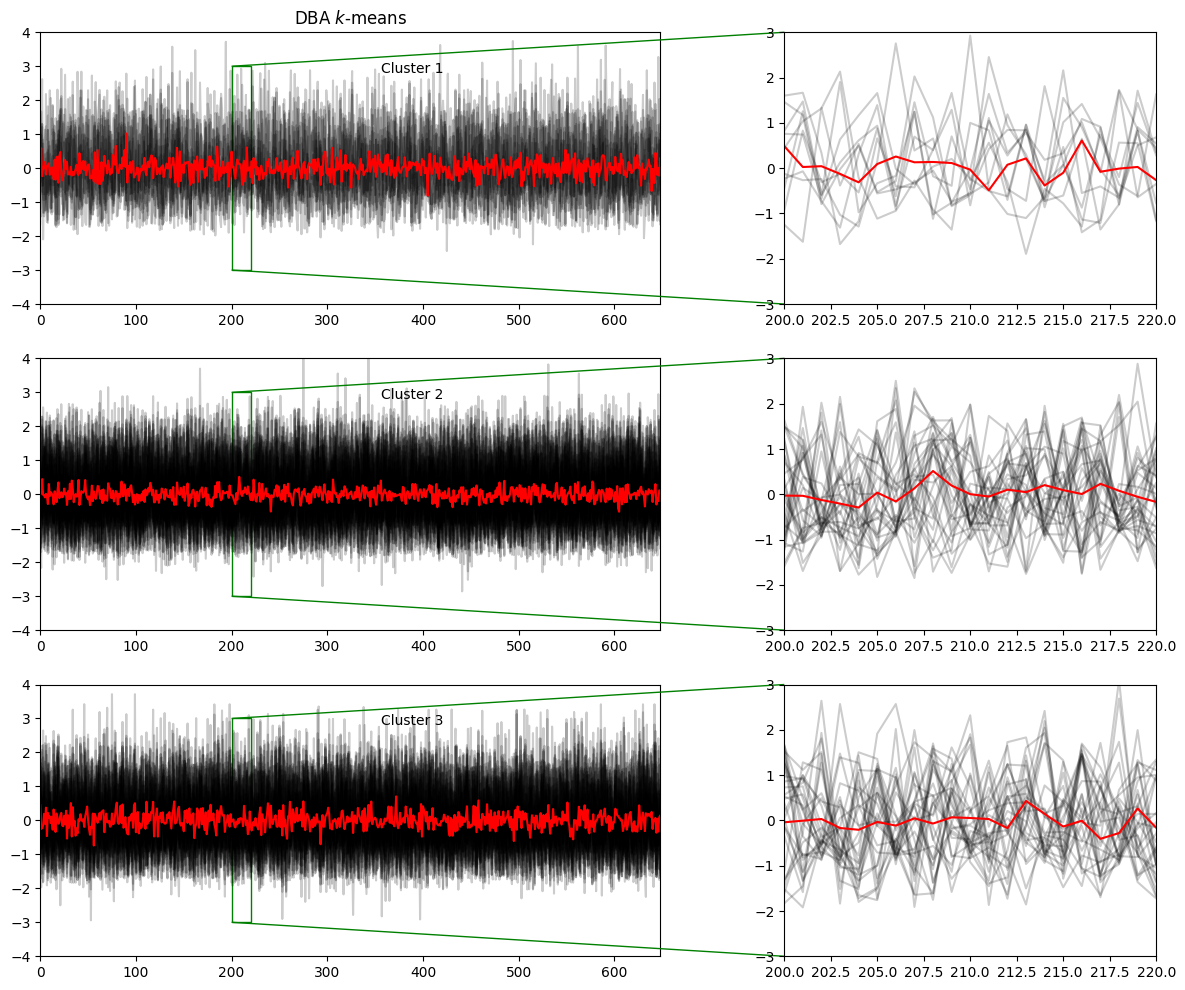

In [84]:
zoom_in_plot(X_train, y_pred_DBA, km, sz, 'DBA')

In [85]:
with open('intermediate_with_out/DBA_wind.pickle', 'wb') as f:
    pickle.dump(dba_km, f)

In [86]:
assets_per_cluster_dba = pd.DataFrame()

assets_per_cluster_dba['asset_id'] = df_subset['asset_id'].unique()
assets_per_cluster_dba['cluster_label'] = y_pred_DBA

In [87]:
assets_clusters = assets_per_cluster_dba.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [6, 9, 17, 18, 23, 31, 33, 34, 35, 57]
Cluster 1: [1, 4, 5, 8, 10, 11, 14, 15, 16, 19, 24, 25, 36, 37, 43, 45, 46, 47, 48, 49, 52, 53, 54, 55, 60, 61, 62, 63, 64, 68, 69]
Cluster 2: [0, 2, 3, 7, 12, 13, 20, 21, 22, 26, 27, 28, 29, 30, 32, 38, 39, 40, 41, 42, 44, 50, 51, 56, 58, 59, 65, 66, 67, 70]


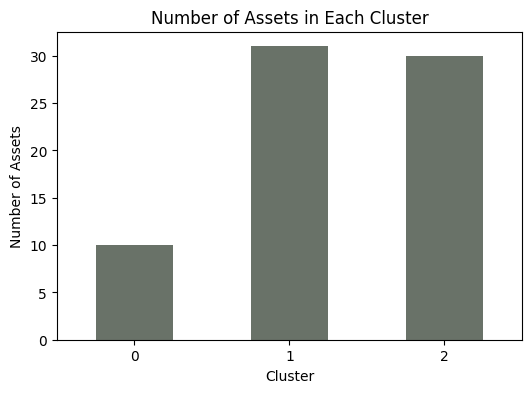

In [88]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = assets_per_cluster_dba['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [89]:
for cluster_label, count in cluster_counts.items():
    column_name = f'Cluster {cluster_label}'  # Generate column name dynamically
    asset_per_cluster.loc[1, column_name] = count

asset_per_cluster.loc[1, 'Metric'] = 'DBA'

asset_per_cluster

,Metric,Cluster 0,Cluster 1,Cluster 2
0,Euclidean,20,30,21
1,DBA,10,31,30


In [99]:
merged_df = df_wind.merge(assets_per_cluster_dba, on='asset_id', how='left')

In [100]:
merged_df.to_csv('intermediate_with_out/results_raw_wind_dba.csv', index = False)

## Soft DTW k-means

In [90]:
# Soft-DTW-k-means
print("Soft-DTW k-means")
sdtw_km = TimeSeriesKMeans(n_clusters=3,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=seed)
                           
y_pred_soft_dtw = sdtw_km.fit_predict(X_train)

Soft-DTW k-means


9445734.366 --> 3942605.190 --> 3936035.766 --> 3933506.982 --> 3931914.430 --> 3930580.324 --> 3929312.860 --> 3927943.904 --> 3927595.516 --> 3927033.745 --> 3926972.639 --> 3926918.830 --> 3926871.837 --> 3926868.745 --> 3926863.982 --> 3926864.251 --> 3926864.250 --> 3926864.247 --> 3926864.263 --> 3926864.263 --> 3926864.264 --> 3926864.265 --> 3926864.265 --> 


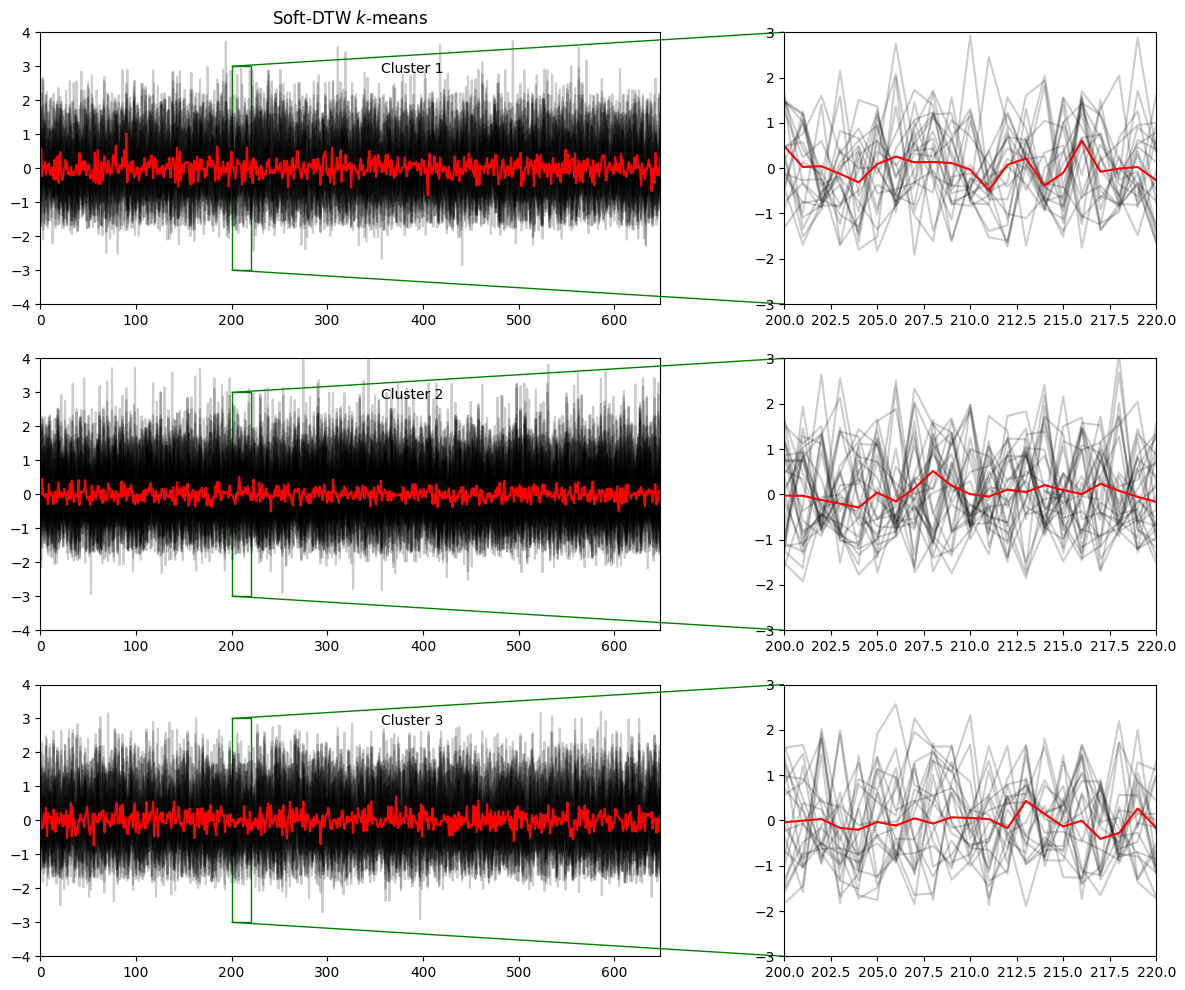

In [91]:
zoom_in_plot(X_train, y_pred_soft_dtw, km, sz, 'Soft-DTW')

In [92]:
with open('intermediate_with_out/sdtw_wind.pickle', 'wb') as f:
    pickle.dump(sdtw_km, f)

In [93]:
assets_per_cluster_soft_dtw = pd.DataFrame()

assets_per_cluster_soft_dtw['asset_id'] = df_subset['asset_id'].unique()
assets_per_cluster_soft_dtw['cluster_label'] = y_pred_soft_dtw

In [94]:
assets_clusters = assets_per_cluster_soft_dtw.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [1, 4, 6, 16, 18, 26, 31, 37, 39, 40, 41, 44, 45, 47, 49, 51, 52, 54, 56, 61, 63]
Cluster 1: [9, 10, 11, 12, 14, 15, 17, 19, 20, 22, 25, 27, 28, 29, 30, 32, 33, 35, 48, 50, 55, 58, 60, 62, 65, 66, 67, 69, 70]
Cluster 2: [0, 2, 3, 5, 7, 8, 13, 21, 23, 24, 34, 36, 38, 42, 43, 46, 53, 57, 59, 64, 68]


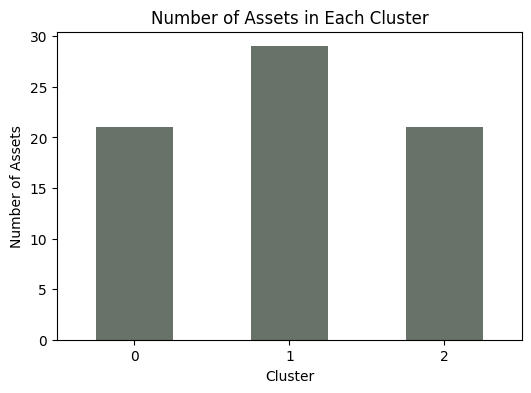

In [95]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = assets_per_cluster_soft_dtw['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [96]:
for cluster_label, count in cluster_counts.items():
    column_name = f'Cluster {cluster_label}'  # Generate column name dynamically
    asset_per_cluster.loc[2, column_name] = count

asset_per_cluster.loc[2, 'Metric'] = 'Soft DTW'

asset_per_cluster

,Metric,Cluster 0,Cluster 1,Cluster 2
0,Euclidean,20,30,21
1,DBA,10,31,30
2,Soft DTW,21,29,21


In [97]:
merged_df = df_wind.merge(assets_per_cluster_soft_dtw, on='asset_id', how='left')

In [98]:
merged_df.to_csv('intermediate_with_out/results_raw_wind_soft_dtw.csv', index = False)